In [1]:
%matplotlib inline
import os
import sys
import numpy as np

from sapsan.lib.backends.fake import FakeBackend
from sapsan.lib.backends.mlflow import MLflowBackend
from sapsan.lib.data.hdf5_dataset import HDF5Dataset
from sapsan.lib.data import EquidistantSampling
from sapsan.lib.estimator import KRR, KRRConfig
from sapsan.lib.experiments.evaluate import Evaluate
from sapsan.lib.experiments.train import Train

/home/pkarpov/anaconda3/lib/python3.8/site-packages/plotly/express/_doc.py:451: DeprecationWarning:

inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()

/home/pkarpov/anaconda3/lib/python3.8/site-packages/catalyst/tools/registry.py:45: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working



In [2]:
#--- Experiment tracking backend ---
experiment_name = "KRR experiment"

#Fake (disable backend)
tracking_backend = FakeBackend(experiment_name)

#MLflow
#launch mlflow with: mlflow ui --port=9000
#uncomment tracking_backend to use mlflow

MLFLOW_HOST = "localhost"
MLFLOW_PORT = 9000

#tracking_backend = MLflowBackend(experiment_name, MLFLOW_HOST, MLFLOW_PORT)

/home/pkarpov/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [3]:
#--- Data setup ---
#In the intereset of loading and training multiple timesteps
#one can specify which checkpoints to use and where
#they appear in the path via syntax: {checkpoint:format}
#
#Next, you need to specify which features to load; let's assume 
#        path = "{feature}.h5"
#
# 1) If in different files, then specify features directly;
#    The default HDF5 label will be the last label in the file
#    Ex: features = ['velocity', 'denisty', 'pressure']
# 2) If in the same, then duplicate the name in features
#    and specify which labels to pull
#    Ex: features = ["data", "data", "data"]
#        feature_labels = ['velocity', 'density', 'pressure']

path = 'data/t{checkpoint:1.0f}/{feature}_dim128_2d.h5'
features = ['u']
target = ['u']


#Dimensionality of your data per axis
INPUT_SIZE = (128,128)

#Reduce dimensionality of each axis to
SAMPLE_TO = (64,64)

#Sampler to use for reduction
sampler = EquidistantSampling(INPUT_SIZE, SAMPLE_TO)

In [4]:
#--- Train the model ---
#Machine Learning model to use

#Configuration of the model parameters:
#    alpha - rbf kernel hyperparameter
#    gamma - rbf kernel hyperparameter
estimator = KRR(
    config=KRRConfig(gamma=1.778, alpha=0.001)
)

#Load the data
data_loader = HDF5Dataset(path=path,
                   features=features,
                   target=target,
                   checkpoints=[0],
                   input_size=INPUT_SIZE,
                   sampler=sampler, 
                   flat = True)
x, y = data_loader.load()

#ex: predict one component of the target
y = np.array([y[0]])

#Set the experiment
training_experiment = Train(backend=tracking_backend,
                            model=estimator,
                            inputs=x, targets=y,
                            data_parameters = data_loader.get_parameters())
#Train the model
training_experiment.run()

Loading 'u00010' from file 'data/t0/u_dim128_2d.h5'
Loading 'u00010' from file 'data/t0/u_dim128_2d.h5'


/home/pkarpov/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning:

Ill-conditioned matrix (rcond=4.15775e-08): result may not be accurate.



{'runtime': 2.256838321685791}

/home/pkarpov/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Loading 'u00010' from file 'data/t0/u_dim128_2d.h5'
Loading 'u00010' from file 'data/t0/u_dim128_2d.h5'


runtime:  0.6470620632171631


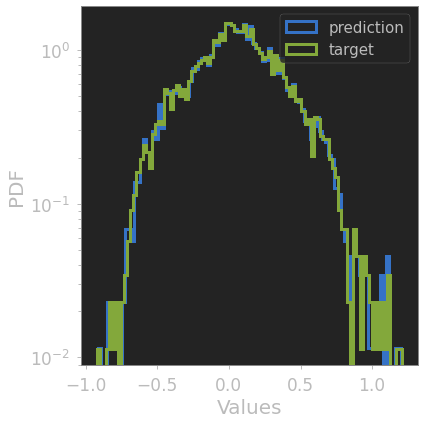

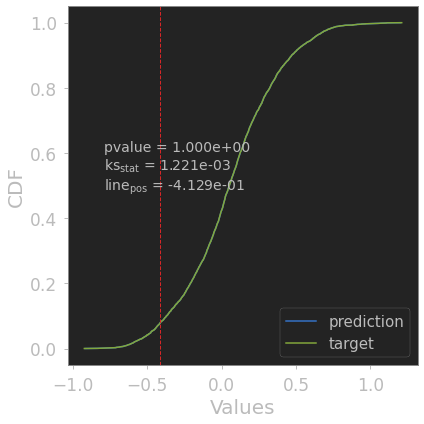

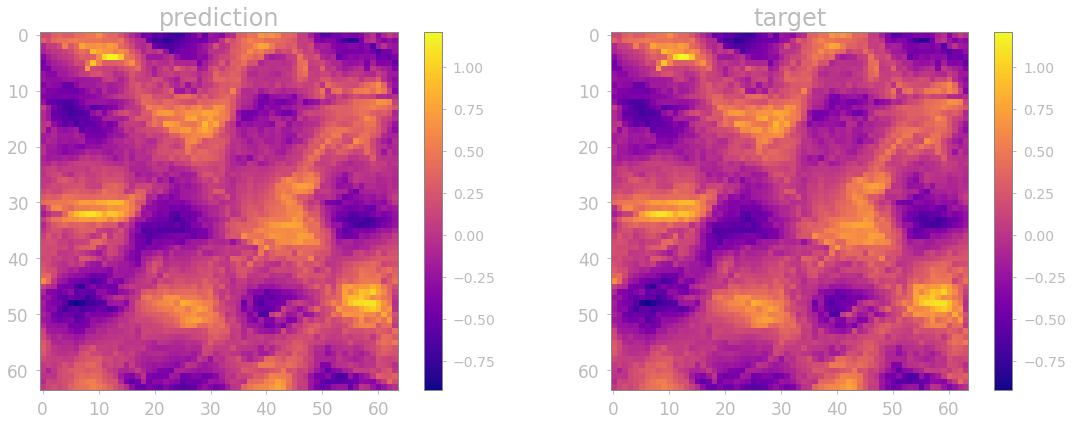

In [5]:
#--- Test the model ---
#Load the test data
data_loader = HDF5Dataset(path=path,
                   features=features,
                   target=target,
                   checkpoints=[0],
                   input_size=INPUT_SIZE,
                   sampler=sampler, 
                   flat = True)
x, y = data_loader.load()

#ex: predict one component of the target
y = np.array([y[0]])

#Set the test experiment
evaluation_experiment = Evaluate(backend=tracking_backend,
                                 model=training_experiment.model,
                                 inputs=x, targets=y,
                                 data_parameters = data_loader.get_parameters(),
                                 flat=True)

#Test the model
target_cube, pred_cube = evaluation_experiment.run()